# Bayesian neural network

First, we load the modules we need:

In [84]:
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import distrax as dx

from coinem.model import AbstractModel

# Pyplot for plots.
import matplotlib.pyplot as plt 

## Model

Decribe.

In [130]:
@dataclass
class BayesNN(AbstractModel):
    """Base class for p(θ, x)."""
    images: Array
    labels: Array
    w_shape: tuple[int, int] = (40, 784)
    v_dim: tuple[int, int] = (2, 40)
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"]) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (2,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """

        alpha, beta = theta

        w_flat = latent[:self.w_shape[0] * self.w_shape[1]]
        w = w_flat.reshape(self.w_shape)

        v_flat = latent[self.w_shape[0] * self.w_shape[1]:]
        v = v_flat.reshape(self.v_dim)


        log_prior_w = dx.Normal(0.0, jnp.exp(2.0 * alpha)).log_prob(w_flat).sum()
        log_prior_v = dx.Normal(0.0, jnp.exp(2.0 * beta)).log_prob(v_flat).sum()


        def _log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            arg = jnp.dot(v, jnp.tanh(jnp.dot(w, image.flatten())))
            return jax.nn.log_softmax(arg)


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        def _log_likelihood(images, labels):
            # Log-likelihood for set of images and labels, vectorized over particles.
            return (_log_nn_vec(images)[jnp.arange(labels.size), labels]).sum()

        # Compute log-probability.
        return _log_likelihood(self.images, self.labels) + log_prior_w + log_prior_v # log p(y|x) + log p(x|theta)

In [144]:
y = 0

v = jnp.array([1., 2.])

v[0, :] * (1-y) + v[1, :] * y

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

Next, we load and curate the dataset:

In [131]:
#@title Load, subsample, and normalize MNIST dataset.
import numpy as np

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries so that they have mean zero and unit standard 
# across the dataset:'''
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

We can now run the algorithms using an 80/20 training/test split of the data:

In [132]:
# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

# Set approximation parameters:
h = 1e-1 # Step-size. 
K = 10  # Number of steps.
N = 10  # Number of particles.

alpha = jnp.array(0.0)
beta = jnp.array(0.0)
theta = jnp.array([alpha, beta])
key = jr.PRNGKey(42)


# Initialize particle cloud by sampling prior:'
w_flat = jnp.exp(alpha) * jr.normal(key, (N, 40 * 28**2))  # Input layer weights.
v_flat = jnp.exp(beta) * jr.normal(key, (N, 2*40))  # Output layer weights.

latent = jnp.concatenate((w_flat, v_flat), axis=1)


from coinem.zoo import coin_svgd


model = BayesNN(itrain, ltrain)
x_coin, theta_coin = coin_svgd(model, latent, theta, K, alpha=100)

KeyboardInterrupt: 

In [126]:
from coinem.zoo import pgd
model = BayesNN(itrain, ltrain)
x_pgd, theta_pgd = pgd(model, latent, theta, 25, step_size=1e-4)

In [128]:
theta_pgd

Array([[ 0.0000000e+00,  0.0000000e+00],
       [-4.3047224e-03,  2.9330811e-05],
       [ 1.0019090e-01, -4.6332563e-05],
       [-1.9738113e+00, -2.1462904e-04],
       [ 1.6817635e+04, -4.5987670e-04],
       [           nan, -7.7647978e-04],
       [           nan, -1.1532716e-03],
       [           nan, -1.5947493e-03],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [        

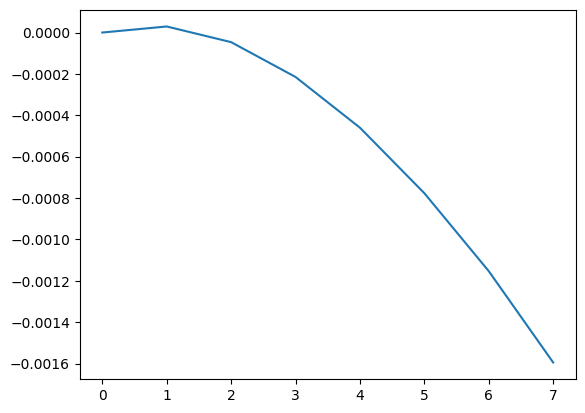

In [112]:
# plt.plot(theta_coin[:, 0])
plt.plot(theta_pgd[:, 1])
# plt.plot(theta_coin[:, 1])
# plt.plot(theta_pgd[:, 1])

As a sanity check, we plot the test error throughout training:

In [ ]:
plt.plot(error_pgd, label='PGD') 
plt.plot(error_pqn, label='PQN')
plt.plot(error_pmga, label='PMGD')
plt.plot(error_soul, label='SOUL')
plt.plot(error_coin, label='Coin')
plt.xlim([-K/100, K])
plt.legend(loc='upper right')

As expected, the error decreases during training for all four algorithms. PGD, PQN, PMGD achieve noticeably smaller errors:

In [ ]:
plt.plot(error_pgd, label='PGD') 
plt.plot(error_pqn, label='PQN')
plt.plot(error_pmga, label='PMGD')
plt.plot(error_soul, label='SOUL')
plt.plot(error_coin, label='Coin')
plt.ylim([0, 0.1])
plt.xlim([-K/100, K])

## Figure 4a

The parameter estimates seem to converge to various local optima:

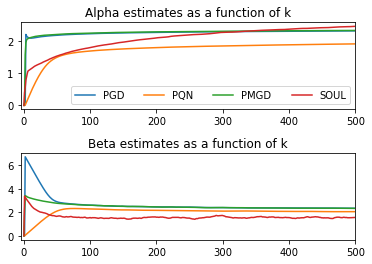

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(a_pgd, label='PGD') 
plt.plot(a_pqn, label='PQN')
plt.plot(a_pmga, label='PMGD')
plt.plot(a_soul, label='SOUL')
plt.title('Alpha estimates as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(b_pgd, label='PGD') 
plt.plot(b_pqn, label='PQN')
plt.plot(b_pmga, label='PMGD')
plt.plot(b_soul, label='SOUL')
plt.title('Beta estimates as a function of k')
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

## Figure 4b

The posterior approximations produced by SOUL are more peaked than those produced by PGD, PQN, and PMGD:

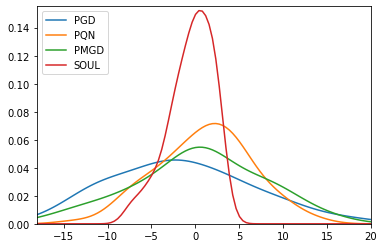

In [ ]:
# Choose a random weight for the input layer:
oi = np.random.randint(0, w0[:, 0, 0].size)  # Output index.
ii = np.random.randint(0, w0[0, :, 0].size)  # Input index.

# Generate KDEs:
from scipy import stats

kde_min = np.min([w_pgd[oi, ii, :], w_pqn[oi, ii, :], 
              w_pmga[oi, ii, :], w_soul[oi, ii, :]])
kde_max = np.max([w_pgd[oi, ii, :], w_pqn[oi, ii, :],
              w_pmga[oi, ii, :], w_soul[oi, ii, :]])
xaxis = np.linspace(kde_min, kde_max, num=100)

kde_pgd = stats.gaussian_kde(w_pgd[oi, ii, :])(xaxis)
kde_pqn = stats.gaussian_kde(w_pqn[oi, ii, :])(xaxis)
kde_pmga = stats.gaussian_kde(w_pmga[oi, ii, :])(xaxis)
kde_soul = stats.gaussian_kde(w_soul[oi, ii, :])(xaxis)

# Plot KDEs:
plt.plot(xaxis, kde_pgd, label='PGD')
plt.plot(xaxis, kde_pqn, label='PQN')
plt.plot(xaxis, kde_pmga, label='PMGD')
plt.plot(xaxis, kde_soul, label='SOUL')
plt.ylim([0, 1.02*kde_soul.max()])
plt.xlim([kde_min, kde_max])
plt.legend(loc='upper left')

## Figure 4c

This is likely the reason why PGD, PQN, and PMGD achieve lower errors than SOUL. We observe the same sort of behaviour if we plot log pointwise predictive densities rather than test errors:

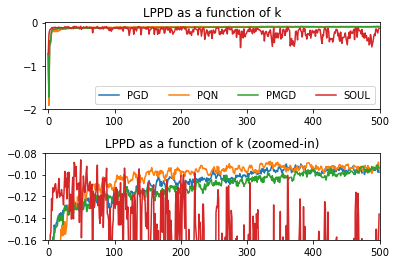

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(lppd_pgd, label='PGD') 
plt.plot(lppd_pqn, label='PQN')
plt.plot(lppd_pmga, label='PMGD')
plt.plot(lppd_soul, label='SOUL')
plt.title('LPPD as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(lppd_pgd, label='PGD') 
plt.plot(lppd_pqn, label='PQN')
plt.plot(lppd_pmga, label='PMGD')
plt.plot(lppd_soul, label='SOUL')
plt.title('LPPD as a function of k (zoomed-in)')
plt.ylim([-0.16, -0.08])
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

# Table 2

We benchmark the predictive performances and computation times of the algorithms by running them several times. To this end, we remove the per-time-step performance metric calculations from the algorithms: 

In [ ]:
#@title Algorithms without LPPD and test error computations.

def pgd(ltrain, itrain, h, K, a, b, w, v):
    # Extract dimensions of latent variables:
    Dw = w[:, :, 0].size  # Dimension of w.
    Dv = v[:, :, 0].size  # Dimension of v.

    for k in range(K):
        # Temporarily store current particle cloud:
        wk = w  # w components.
        vk = v  # v components.

        # Update parameter estimates (note that we are using the heuristic 
        # discussed in Section 2 of the paper; i.e., dividing the alpha-gradient
        # by Dw and the beta-gradient by Dv):'''
        a = np.append(a, a[k] + h*ave_grad_param(wk, a[k])/Dw)  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(vk, b[k])/Dv)  # Beta.

        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain) + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain) + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

    return a, b, w, v


def pqn(ltrain, itrain, h, K, a, b, w, v):

    for k in range(K):
        # Temporarily store current particle cloud:
        wk = w  # w components.
        vk = v  # v components.

        # Update parameter estimates:
        a = np.append(a, a[k] + h*ave_grad_param(wk, a[k])
                                  /ave_neg_hess_param(wk, a[k]))  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(vk, b[k])
                                  /ave_neg_hess_param(vk, b[k]))  # Beta.
        
        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

    return a, b, w, v


def pmga(ltrain, itrain, h, K, w, v):
    # Compute initial parameter estimates:
    a = np.array([optimal_param(w)])  # Alpha estimates.
    b = np.array([optimal_param(v)])  # Beta estimates.

    for k in range(K):
        # Temporarily store current particle cloud:
        wk = w  # w components.
        vk = v  # v components.
        
        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

        # Update parameter estimates:
        a = np.append(a, optimal_param(w))  # Alpha.
        b = np.append(b, optimal_param(v))  # Beta.

    return a, b, w, v


def soul(ltrain, itrain, h, K, a, b, w, v):
    # Extract dimensions of latent variables:
    Dw = w[:, :, 0].size  # Dimension of w.
    Dv = v[:, :, 0].size  # Dimension of v.

    for k in range(K):
        # Initliaze new ULA chain at final state of previous ULA chain:
        wkn = w[:, :, -1].reshape((w[:, 0, 0].size, w[0, :, 0].size, 1))
        vkn = v[:, :, -1].reshape((v[:, 0, 0].size, v[0, :, 0].size, 1))

        # Run ULA chain:
        for n in range(w[0, 0, :].size):
            # Take a step:
            wkn = (wkn + h*wgrad(wkn, vkn, a[k], b[k], itrain, ltrain)
                       + jnp.sqrt(2*h) * np.random.normal(0, 1, wkn.shape))
            vkn = (vkn + h*vgrad(wkn, vkn, a[k], b[k], itrain, ltrain)
                       + jnp.sqrt(2*h) * np.random.normal(0, 1, vkn.shape))
            
            # Store state:
            w[:, :, n] = wkn.reshape(w[:, :, 0].shape)
            v[:, :, n] = vkn.reshape(v[:, :, 0].shape)

        # Update parameter estimates (note that we are using the heuristic 
        # discussed in Section 2 of the paper; i.e., dividing the 
        # alpha-gradient by Dw and the beta-gradient by Dv):
        a = np.append(a, a[k] + h*ave_grad_param(w, a[k])/Dw)  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(v, b[k])/Dv)  # Beta.

    return a, b, w, v

## Predictive performance

We start with the performances:

In [ ]:
M = 10 # Number of runs.
N = 100 # Number of particles.

# Initialize arrays storing the LPPDs and test errors:
lppd_pgd = np.zeros((M))
lppd_pqn = np.zeros((M))
lppd_pmga = np.zeros((M))
lppd_soul = np.zeros((M))

error_pgd = np.zeros((M))
error_pqn = np.zeros((M))
error_pmga = np.zeros((M))
error_soul = np.zeros((M))

for m in range(M):
    print('Run ' + str(m) + ' out of ' + str(M) + '.')
    
    # Randomize the initialization of the particle cloud:
    w0 = np.exp(a0)*np.random.normal(0, 1, (40, 28**2, N))  # w-components.
    v0 = np.exp(b0)*np.random.normal(0, 1, (2, 40, N))  # v-components.
    
    # Randomize the 80/20 testing/training split of the data:
    itrain, itest, ltrain, ltest = train_test_split(images, labels, 
                                                    test_size=0.2,
                                                    random_state=m)

    # Run the algorithms:
    _, _, w_pgd, v_pgd = pgd(ltrain, itrain, h, K, a0, b0, w0, v0)
    _, _, w_pqn, v_pqn = pqn(ltrain, itrain, h, K, a0, b0, w0, v0)
    _, _, w_pmga, v_pmga = pmga(ltrain, itrain, h, K, w0, v0)
    _, _, w_soul, v_soul = soul(ltrain, itrain, h, K, a0, b0, w0, v0)

    # Compute LPPDs:
    lppd_pgd[m] = log_pointwise_predrictive_density(w_pgd, v_pgd, itest, ltest)
    lppd_pqn[m] = log_pointwise_predrictive_density(w_pqn, v_pqn, itest, ltest)
    lppd_pmga[m] = log_pointwise_predrictive_density(w_pmga, v_pmga, itest, ltest)
    lppd_soul[m] = log_pointwise_predrictive_density(w_soul, v_soul, itest, ltest)

    # Compute test errors:
    error_pgd[m] = test_error(w_pgd, v_pgd, itest, ltest)
    error_pqn[m] = test_error(w_pqn, v_pqn, itest, ltest)
    error_pmga[m] = test_error(w_pmga, v_pmga, itest, ltest)
    error_soul[m] = test_error(w_soul, v_soul, itest, ltest)

# Print statistics (mean +- standard deviation):
print('LPPDs:')
print('PGD: '+str(lppd_pgd.mean())+' \u00B1 '+str(lppd_pgd.std())+'.')
print('PQN: '+str(lppd_pqn.mean())+' \u00B1 '+str(lppd_pqn.std())+'.')
print('PMGD: '+str(lppd_pmga.mean())+' \u00B1 '+str(lppd_pmga.std())+'.')
print('SOUL: '+str(lppd_soul.mean())+' \u00B1 '+str(lppd_soul.std())+'.')

print('Test errors:')
print('PGD: '+str(error_pgd.mean())+' \u00B1 '+str(error_pgd.std())+'.')
print('PQN: '+str(error_pqn.mean())+' \u00B1 '+str(error_pqn.std())+'.')
print('PMGD: '+str(error_pmga.mean())+' \u00B1 '+str(error_pmga.std())+'.')
print('SOUL: '+str(error_soul.mean())+' \u00B1 '+str(error_soul.std())+'.')

Run 0 out of 10.


NameError: name 'a0' is not defined

## Runtime

Lastly, we obtain runtime statistics using IPython's timeit magic (note that Colab can be set to run on a CPU, GPU, or TPU by selecting Runtime --> Change runtime type --> Hardware accelerator):

In [ ]:
from timeit import repeat

# Time the algorithms:
t_pgd = np.array(repeat(stmt='pgd(ltrain, itrain, h, K, a0, b0, w0, v0)',
                       number=1, repeat=M, globals=globals()))
t_pqn = np.array(repeat(stmt='pqn(ltrain, itrain, h, K, a0, b0, w0, v0)',
                       number=1, repeat=M, globals=globals()))
t_pmga = np.array(repeat(stmt='pmga(ltrain, itrain, h, K, w0, v0)',
                        number=1, repeat=M, globals=globals()))
t_soul = np.array(repeat(stmt='soul(ltrain, itrain, h, K, a0, b0, w0, v0)',
                        number=1, repeat=M, globals=globals()))

# Print statistics (mean +- standard deviation):
print('Runtimes:')
print('PGD: '+str(t_pgd.mean())+' \u00B1 '+str(t_pgd.std())+'.')
print('PQN: '+str(t_pqn.mean())+' \u00B1 '+str(t_pqn.std())+'.')
print('PMGD: '+str(t_pmga.mean())+' \u00B1 '+str(t_pmga.std())+'.')
print('SOUL: '+str(t_soul.mean())+' \u00B1 '+str(t_soul.std())+'.')

Runtimes:
PGD: 74.76778770000018 ± 1.412497029258898.
PQN: 77.87597586999982 ± 0.9440582033750415.
PMGD: 76.48166515999984 ± 0.876956851171763.
SOUL: 185.37313661000007 ± 5.5230289929147105.
